# Proyecto: Análisis del Sentimiento en Criptomonedas y su Relación con el Tipo de Cambio

## Objetivo
Evaluar si existe una correlación significativa entre el sentimiento en el mercado de criptomonedas
(medido por el *Fear & Greed Index*) y el tipo de cambio de monedas emergentes como el sol peruano (PEN/USD).




# **Trabajo 1: Obtención y Análisis de la Base de Datos**
**Curso:** Introducción a Machine Learning con Python

**Grupo:** N° 8

**Integrantes:**

1.   Luis Ángel Alejandro Arrieta Feria
2.   Mirelli Thais Jimenez Pulache
3.   Néstor Julio Rivero Escobar

**Tema:** ¿Existe una correlación significativa entre el sentimiento en el mercado de criptomonedas (medido por el *Fear & Greed Index*) y el tipo de cambio de monedas emergentes como el sol peruano?





## Estructura del Notebook
El notebook se organiza en las siguientes secciones:

1. **Obtención de datos**  
   - Fear & Greed Index  
   - Tipo de cambio PEN/USD (BCRP)  
   - DXY, VIX y BTC  

2. **Unificación de datos**  
   Consolidación de todas las fuentes en un único DataFrame para facilitar el análisis.  

3. **Análisis exploratorio**  
   Estadísticas descriptivas, visualización de tendencias y correlaciones.  

4. **Conclusiones**  
   Discusión sobre los hallazgos y su relevancia en el contexto del mercado cambiario.  

# **Descargar Fear & Greed**


En este apartado se obtiene el índice de "Miedo y Codicia" (*Fear & Greed Index*),
publicado diariamente y utilizado como medida del sentimiento en el mercado de criptomonedas.

**Objetivo:**  
- Incorporar un indicador de sentimiento que complemente los datos financieros.  

**Procedimiento:**  
- Se realiza una consulta a la fuente de datos (API o repositorio en línea).  
- Se estructuran los datos en un DataFrame de pandas para su posterior análisis.

In [78]:
# ============================
# 1. Importamos librerías
# ============================
import re
import requests # Para hacer solicitudes HTTP y conectarnos al API del BCRP
import pandas as pd # Para manejar y analizar datos en tablas
import numpy as np # Para operaciones matemáticas y numéricas
import yfinance as yf # Para descargar datos financieros de Yahoo Finance
import matplotlib.pyplot as plt # Para crear gráficos básicos
import seaborn as sns # Para visualización estadística avanzada y gráficos mejorados

# Configuración visual
sns.set_style('whitegrid') # Estilo de fondo con cuadrícula clara
plt.style.use('seaborn-v0_8-deep') # Estilo visual con colores definidos por seaborn

# ============================
# 2. Parámetros generales
# ============================
periodo_inicial = "2018-06-01"   # Fecha de inicio de los datos
periodo_final   = "2025-06-30"   # Fecha de fin de los datos

# ============================
# 3. Fear & Greed Index (Alternative.me API)
# ============================
url_fng = "https://api.alternative.me/fng/?limit=0&format=json" # URL de la API del Fear & Greed Index
response_fng = requests.get(url_fng) # Hacemos la solicitud a la API
data_fng = response_fng.json() # Convertimos la respuesta en formato JSON

# Procesamos la data
fng = pd.DataFrame(data_fng['data']) # Transformamos la parte útil en un DataFrame

# Conversión y limpieza
fng['date'] = pd.to_datetime(fng['timestamp'].astype(int), unit='s') # Convertimos timestamp a fechas legibles
fng = fng[['date', 'value', 'value_classification']].rename(  # Seleccionamos columnas clave y renombramos
    columns={'value': 'FGI', 'value_classification': 'classification'}
)
fng['FGI'] = pd.to_numeric(fng['FGI'], errors='coerce') # Convertimos la columna FGI a valores numéricos
fng = fng.sort_values('date').set_index('date') # Ordenamos por fecha y la usamos como índice
fng = fng.loc[periodo_inicial:]  # Cortamos desde inicio (se limitará al final más adelante)

# Resumen
print("FGI:", fng.index.min(), "->", fng.index.max(), "| registros:", len(fng))

# Mostrar tabla en Colab (primeros registros)
from IPython.display import display
display(fng.head(10)) # Mostramos las primeras 10 filas


FGI: 2018-06-01 00:00:00 -> 2025-09-13 00:00:00 | registros: 2661


,FGI,classification
date,,
2018-06-01,24,Extreme Fear
2018-06-02,27,Fear
2018-06-03,40,Fear
2018-06-04,41,Fear
2018-06-05,26,Fear
2018-06-06,42,Fear
2018-06-07,38,Fear
2018-06-08,40,Fear
2018-06-09,39,Fear


# **Descarga del tipo de cambio PEN/USD desde el BCRP**


En esta sección se descarga la información del tipo de cambio oficial entre
el sol peruano (PEN) y el dólar estadounidense (USD), proporcionado por
el Banco Central de Reserva del Perú (BCRP).  

**Objetivo:**  
- Contar con la serie histórica del tipo de cambio PEN/USD como variable principal del análisis.  

**Procedimiento:**  
- Se utiliza la API del BCRP para obtener los datos.  
- Se formatea la serie temporal y se almacena en un DataFrame.  

In [79]:
# ============================
# 4. Tipo de Cambio (BCRP API)
# ============================

# Parámetros de la consulta
codigo = "PD04640PD"    # Código de la serie: TC Sistema bancario SBS diario - Venta
formato = "json"        # Formato de salida (JSON)

# Construcción del url y petición GET
url_bcrp = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigo_bcrp}/{formato}/{periodo_inicial}/{periodo_final}"
response_bcrp = requests.get(url_bcrp) # Realizamos la solicitud a la API del BCRP
data_bcrp = response_bcrp.json() # Convertimos la respuesta en JSON

# Procesamiento de los datos
fechas = []     # Lista para almacenar fechas
tc_venta = []   # Lista para almacenar valores del tipo de cambio

for periodo in data_bcrp['periods']:  # Recorremos cada registro en la respuesta
    fechas.append(periodo['name'])  # Guardamos la fecha
    if periodo['values'][0] != 'n.d.':   # Si el valor no está marcado como 'n.d.' (no disponible)
        tc_venta.append(float(periodo['values'][0]))  # Guardamos el valor como número
    else:
        tc_venta.append(np.nan)  # Si está vacío, colocamos NaN

# Construcción del DataFrame
tc = pd.DataFrame({
    'Fecha': pd.to_datetime(fechas, errors='coerce'),  # Convertimos fechas a formato datetime
    'USD_PEN_Venta': tc_venta  # Colocamos los valores de TC
}).set_index('Fecha')  # Usamos la fecha como índice

# Eliminamos filas con datos faltantes, si las hubiera
tc.dropna(inplace=True)  # Quitamos valores NaN

# Vista previa
display(tc.head(10))  # Mostramos las primeras 10 filas
tc.info()  # Información del DataFrame (tipos de datos y registros)


/tmp/ipython-input-674362390.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'Fecha': pd.to_datetime(fechas, errors='coerce'),  # Convertimos fechas a formato datetime


,USD_PEN_Venta
Fecha,
2018-06-01,3.273
2018-06-04,3.273
2018-06-05,3.273
2018-06-06,3.261
2018-06-07,3.262
2018-06-08,3.263
2018-06-11,3.267
2018-06-12,3.270
2018-06-13,3.266


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2018-06-01 to 2025-06-30
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USD_PEN_Venta  1769 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


# **Descarga de DXY, VIX y BTC**

Además de las variables principales, se incorporan indicadores financieros adicionales
que pueden influir en la dinámica de los mercados:

- **DXY**: Índice del valor relativo del dólar estadounidense frente a una canasta de monedas.  
- **VIX**: Índice de volatilidad del mercado de opciones del S&P 500, conocido como "índice del miedo".  
- **BTC**: Precio histórico de Bitcoin, principal criptomoneda de referencia.  

**Objetivo:**  
- Ampliar la base de datos con variables macro y financieras que puedan correlacionarse
con el tipo de cambio y el sentimiento en criptomonedas.  

**Procedimiento:**  
- Se consultan APIs o fuentes de datos abiertas.  
- Se generan DataFrames individuales para cada indicador.  

In [80]:
# ============================
# 5. Variables de control (Yahoo Finance)
# ============================

# Nota: yfinance excluye 'end', pedimos +1 día y luego recortamos
yf_end = (pd.to_datetime(periodo_final) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
tickers = ['DX-Y.NYB', '^VIX', 'BTC-USD']

control_df = yf.download(tickers, start=periodo_inicial, end=yf_end)['Close']
control_df.rename(columns={'DX-Y.NYB':'DXY','^VIX':'VIX','BTC-USD':'BTC_USD'}, inplace=True)
control_df = control_df[control_df.index <= pd.to_datetime(periodo_final)].sort_index()

# Resumen
print("Control vars:", control_df.index.min().date(), "->", control_df.index.max().date(), "| registros:", len(control_df))
print("Última fila (fecha límite):")
display(control_df.tail(10))

/tmp/ipython-input-3256995057.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  control_df = yf.download(tickers, start=periodo_inicial, end=yf_end)['Close']
[*********************100%***********************]  3 of 3 completed

Control vars: 2018-06-01 -> 2025-06-30 | registros: 2587
Última fila (fecha límite):


Ticker,BTC_USD,DXY,VIX
Date,,,
2025-06-21,102257.406250,NaN,NaN
2025-06-22,100987.140625,NaN,NaN
2025-06-23,105577.773438,98.419998,19.83
2025-06-24,106045.632812,97.860001,17.48
2025-06-25,107361.257812,97.680000,16.76
2025-06-26,106960.000000,97.150002,16.59
2025-06-27,107088.429688,97.400002,16.32
2025-06-28,107327.703125,NaN,NaN
2025-06-29,108385.570312,NaN,NaN


# **Unificación de data**

En este paso se integran todas las fuentes en un único DataFrame maestro
para facilitar el análisis conjunto.

**Objetivo:**  
- Tener un dataset consolidado con todas las variables: Fear & Greed, PEN/USD, DXY, VIX y BTC.  

**Procedimiento:**  
- Se realizan *joins* entre las series temporales utilizando la fecha como clave común.  
- Se manejan valores faltantes (si los hubiera) y se ajusta la frecuencia temporal.  

In [81]:
# ============================
# 6. Unificación de todas las series
# ============================

# Definimos calendario diario completo
min_date = min(fng.index.min(), tc_df.index.min(), control_df.index.min())
max_date = pd.to_datetime(periodo_final)
full_index = pd.date_range(min_date, max_date, freq='D')

# Reindexamos cada serie al calendario completo
fng_full = fng.reindex(full_index)
tc_full  = tc_df.reindex(full_index)
ctrl_full= control_df.reindex(full_index)

# Dataset final unificado
dataset = pd.concat([
    fng_full[['FGI']],
    tc_full[['USD_PEN_Venta']],
    ctrl_full[['DXY','VIX','BTC_USD']]
], axis=1)

dataset.index.name = 'Fecha'

# Resumen
print("Dataset final:", dataset.index.min().date(), "->", dataset.index.max().date(), "| shape:", dataset.shape)
print("Non-null counts por variable:")
print(dataset.notna().sum())
display(dataset.tail(10))

# ============================
# 7. Exportar a Excel
# ============================
output_file = "dataset_fgi_tc_peru_full.xlsx"
dataset.to_excel(output_file, sheet_name="data", engine="openpyxl")
print("Archivo Excel exportado:", output_file)
try:
    from google.colab import files
    files.download(output_file)
except Exception:
    pass


Dataset final: 2018-06-01 -> 2025-06-30 | shape: (2587, 5)
Non-null counts por variable:
FGI              2586
USD_PEN_Venta    1769
DXY              1781
VIX              1779
BTC_USD          2587
dtype: int64


,FGI,USD_PEN_Venta,DXY,VIX,BTC_USD
Fecha,,,,,
2025-06-21,49.0,NaN,NaN,NaN,102257.406250
2025-06-22,42.0,NaN,NaN,NaN,100987.140625
2025-06-23,47.0,3.606,98.419998,19.83,105577.773438
2025-06-24,65.0,3.581,97.860001,17.48,106045.632812
2025-06-25,66.0,3.576,97.680000,16.76,107361.257812
2025-06-26,74.0,3.572,97.150002,16.59,106960.000000
2025-06-27,65.0,3.552,97.400002,16.32,107088.429688
2025-06-28,65.0,NaN,NaN,NaN,107327.703125
2025-06-29,68.0,NaN,NaN,NaN,108385.570312


Archivo Excel exportado: dataset_fgi_tc_peru_full.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **GRÁFICOS**

Con los datos unificados, se procede a realizar un análisis descriptivo y visual.  

**Acciones realizadas:**  
- Cálculo de estadísticas descriptivas (media, varianza, correlaciones).  
- Visualización de tendencias en el tiempo (series históricas).  
- Identificación de posibles patrones o relaciones entre variables.  

**Objetivo:**  
- Obtener una primera comprensión de la dinámica entre el sentimiento del mercado,
el tipo de cambio y los indicadores financieros.  

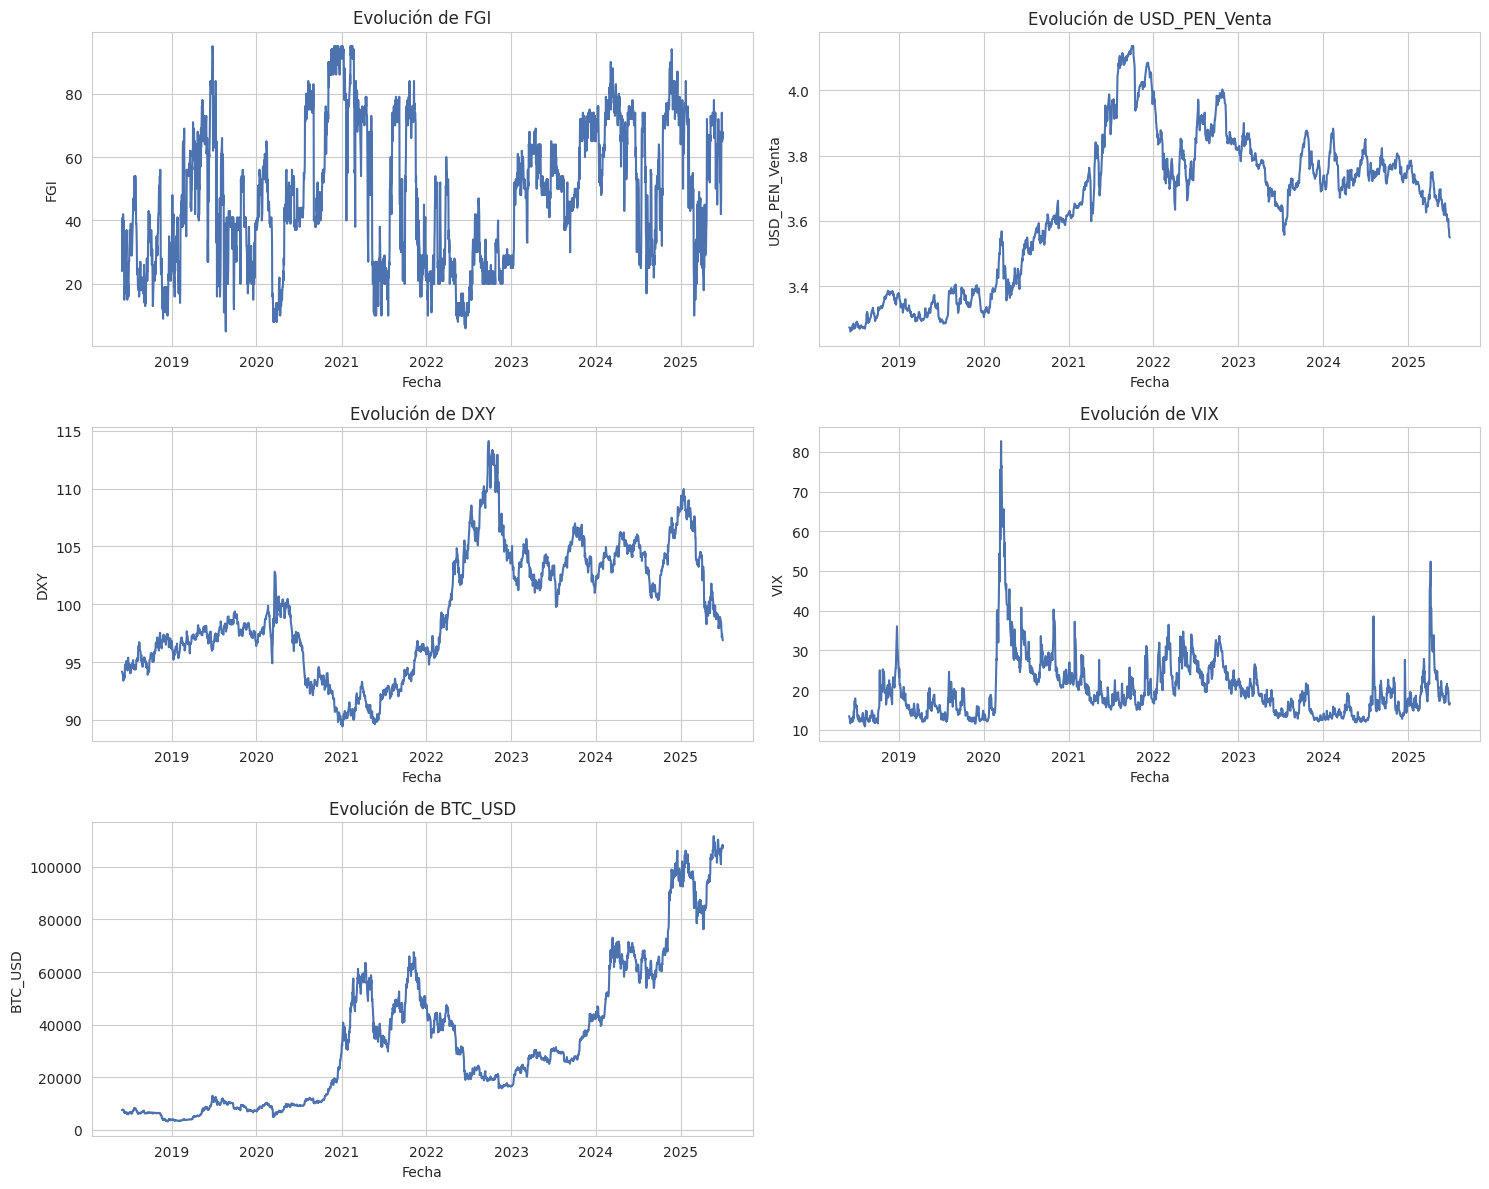

In [82]:
# ============================
# 8. Gráfico lineal y exportación
# ============================
variables = ["FGI", "USD_PEN_Venta", "DXY", "VIX", "BTC_USD"] # Lista de variables a graficar
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.lineplot(data=dataset, x=dataset.index, y=var, ax=axes[i], linewidth=1.5)  # Gráfico de líneas
    axes[i].set_title(f"Evolución de {var}", fontsize=12)  # Título del gráfico
    axes[i].set_xlabel("Fecha") # Etiqueta del eje X
    axes[i].set_ylabel(var) # Etiqueta del eje Y (nombre de la variable)

if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


***Interpretación:***
- El índice de Fear & Greed exhibe una alta volatilidad, moviéndose entre los extremos de "Miedo Extremo" (cerca de 10) y "Codicia Extrema" (picos de 90). Esta volatilidad subraya la sensibilidad del mercado de criptomonedas al sentimiento del inversor, siendo mucho más pronunciada que en los mercados tradicionales. Históricamente, los picos de "Codicia Extrema" a menudo señalan posibles correcciones de precios, mientras que los períodos de "Miedo Extremo" podrían indicar oportunidades de compra.

- El gráfico de evolución del tipo de cambio evidencia una historia de estabilidad inicial, seguida de una crisis de confianza producto de la pandemia que disparó el valor del dólar a un máximo histórico, y posteriormente un período de corrección y recuperación gradual del sol peruano.

- Al inicio del período analizado, el DXY muestra cierta estabilidad con fluctuaciones en un rango relativamente estrecho. Posteriormente, se observa una clara tendencia alcista a partir de 2021. El índice alcanza su punto máximo en 2023. Este período coincidió con un entorno macroeconómico global de alta inflación y las respuestas de los bancos centrales, que iniciaron ciclos de aumento de tasas de interés. Después del pico de 2023, el DXY muestra una corrección y una tendencia general a la baja que se extiende hasta 2025.
Un aspecto relevante es que el tipo de cambio en Perú (USD/PEN) alcanzó su máximo histórico a finales de 2021, principalmente por factores de incertidumbre interna (política). Sin embargo, el hecho de que el dólar se estuviera fortaleciendo globalmente (DXY subiendo) en ese mismo período sin duda contribuyó a esa alza y evitó que el sol se recuperara más rápido. La reciente caída del dólar a nivel global en 2025 que vemos en este gráfico, coincide y ayuda a explicar la tendencia a la baja que también se ve en el tipo de cambio USD/PEN en el mismo año.

- El gráfico del VIX, conocido como el "índice del miedo", ilustra la expectativa de volatilidad del mercado. Su pico extremo en 2020 refleja el pánico inicial por la pandemia de COVID-19. Después de ese shock, la volatilidad se mantuvo elevada por un tiempo, para luego disminuir gradualmente hacia niveles más típicos en los últimos años del período analizado, aunque con fluctuaciones poco habituales durante 2025, causadas muy probablemente por la política arancelaria de EEUU.

- Lo primero que destaca es la alta volatilidad de Bitcoin y la presencia de tendencias alcistas y bajistas muy pronunciadas a lo largo del tiempo. Esto es característico de los activos de criptomonedas. Se observan períodos de crecimiento explosivo, como a finales de 2020 y durante 2021, donde el precio de Bitcoin aumentó considerablemente, alcanzando picos históricos. Después de los picos, también se aprecian correcciones significativas, donde el precio puede caer drásticamente en un período relativamente corto. Esto ocurrió, por ejemplo, después del pico de 2021 y en otros momentos de euforia seguidos de toma de ganancias o cambios en el sentimiento del mercado. Hacia el final del gráfico (2024-2025), se observa una nueva tendencia alcista marcada, llevando a Bitcoin a nuevos máximos históricos.

/tmp/ipython-input-679618931.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = dataset[variables_retornos].pct_change().dropna()
/tmp/ipython-input-679618931.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=[colors[c] for c in counts.index], ax=axes[5])


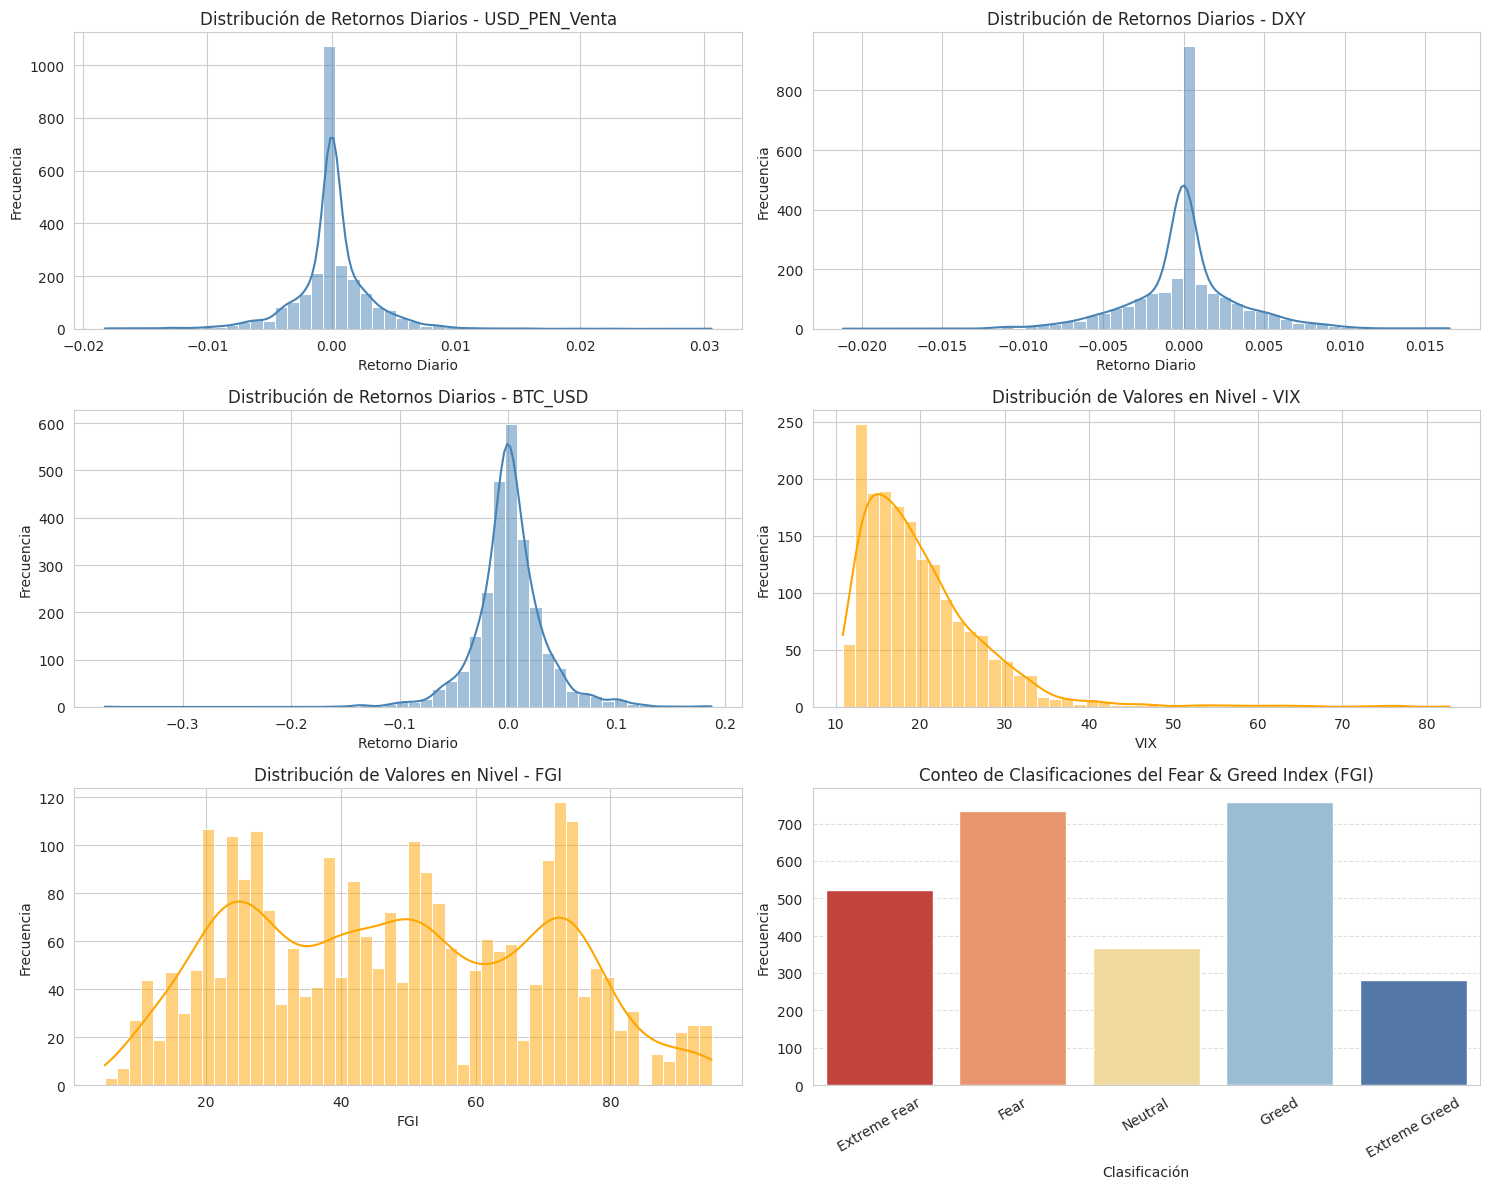

In [83]:
# ============================
# 9. Histogramas y FGI
# ============================

import matplotlib.pyplot as plt
import seaborn as sns

variables_retornos = ["USD_PEN_Venta", "DXY", "BTC_USD"]  # Retornos diarios
variables_nivel    = ["VIX", "FGI"]                        # Valores en nivel

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# 1. Histogramas de retornos diarios

# Calculamos retornos diarios solo para las variables de precio
returns = dataset[variables_retornos].pct_change().dropna()

for i, var in enumerate(variables_retornos):
    sns.histplot(returns[var], kde=True, bins=50, color='steelblue', ax=axes[i])
    axes[i].set_title(f"Distribución de Retornos Diarios - {var}", fontsize=12)
    axes[i].set_xlabel("Retorno Diario")
    axes[i].set_ylabel("Frecuencia")

# 2. Histogramas de valores en nivel
for j, var in enumerate(variables_nivel):
    sns.histplot(dataset[var].dropna(), kde=True, bins=50, color='orange', ax=axes[i+j+1])
    axes[i+j+1].set_title(f"Distribución de Valores en Nivel - {var}", fontsize=12)
    axes[i+j+1].set_xlabel(var)
    axes[i+j+1].set_ylabel("Frecuencia")

# 3. Gráfico de barras FGI
order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
colors = {
    "Extreme Fear": "#d73027",
    "Fear": "#fc8d59",
    "Neutral": "#fee090",
    "Greed": "#91bfdb",
    "Extreme Greed": "#4575b4"
}
counts = fng['classification'].value_counts().reindex(order)

sns.barplot(x=counts.index, y=counts.values, palette=[colors[c] for c in counts.index], ax=axes[5])
axes[5].set_title("Conteo de Clasificaciones del Fear & Greed Index (FGI)", fontsize=12)
axes[5].set_xlabel("Clasificación")
axes[5].set_ylabel("Frecuencia")
axes[5].grid(axis='y', linestyle='--', alpha=0.6)
axes[5].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


***Interpretación:***
- La distribución de los retornos diarios evidencia diferencias importantes en el grado de estabilidad y riesgo de cada activo analizado. En el caso del tipo de cambio USD/PEN, los retornos se concentran fuertemente alrededor de cero, con colas delgadas, lo que refleja una dinámica estable en el corto plazo. Esto es consistente con la intervención activa del Banco Central de Reserva del Perú, que limita la volatilidad cambiaria para preservar la estabilidad financiera. Y asimismo, con el comportamiento típico de monedas emergentes: cierta estabilidad con pequeños ajustes diarios.

- El índice DXY, aunque también presenta una concentración marcada en torno a cero, muestra una dispersión algo mayor que el tipo de cambio local. Ello responde a que el dólar estadounidense se enfrenta a fluctuaciones globales en función de expectativas de política monetaria, inflación y shocks internacionales, aunque sin perder su condición de activo de referencia y reserva.

- El caso del Bitcoin tiene una distribución mucho más ancha y con colas largas. Los retornos del bitcoin son mucho más volátiles: movimientos diarios pueden ser de ±10% o más. Esta dinámica obedece tanto a la falta de regulación en el mercado cripto como a su carácter especulativo, lo que lo convierte en un activo atractivo para inversionistas con alta tolerancia al riesgo, pero poco comparable con la estabilidad de los mercados tradicionales. Podemos corroborar nuestra hipótesis haciendo un análisis del gráfico de barras del Fear & Greed Index, donde hay mucho más miedo y miedo extremo, codicia y codicia extrema, y poca neutralidad.

- La distribución de los valores del VIX muestra asimetría con un sesgo hacia la derecha. La mayor concentración de valores se encuentra en el rango de 10 a 20 puntos, lo que indica que, en condiciones de mercado normales, la volatilidad esperada es baja. No obstante, la distribución presenta una cola derecha larga y pesada, que se extiende hacia valores muy altos, reflejando eventos de alta incertidumbre.

- La distribución de valores del FGI muestra una notable forma bimodal, con dos picos principales en los extremos del gráfico, lo que revela la dinámica emocional y especulativa del mercado cripto. En lugar de concentrarse en un estado de neutralidad, el mercado tiende a oscilar entre dos extremos: un primer pico en la zona de "Miedo" o "Miedo Extremo"  y un segundo pico en la zona de "Codicia" o "Codicia Extrema"

- EN cuanto, a la clasificación categórica del FGI, hay una mayor frecuencia en Greed y Extreme Fear. Esto refuerza la idea de ciclos emocionales extremos en el mercado cripto. La categoría Neutral es la menos frecuente: el mercado rara vez se mantiene en equilibrio.



/tmp/ipython-input-859042491.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = dataset[["USD_PEN_Venta", "DXY", "BTC_USD"]].pct_change().dropna()


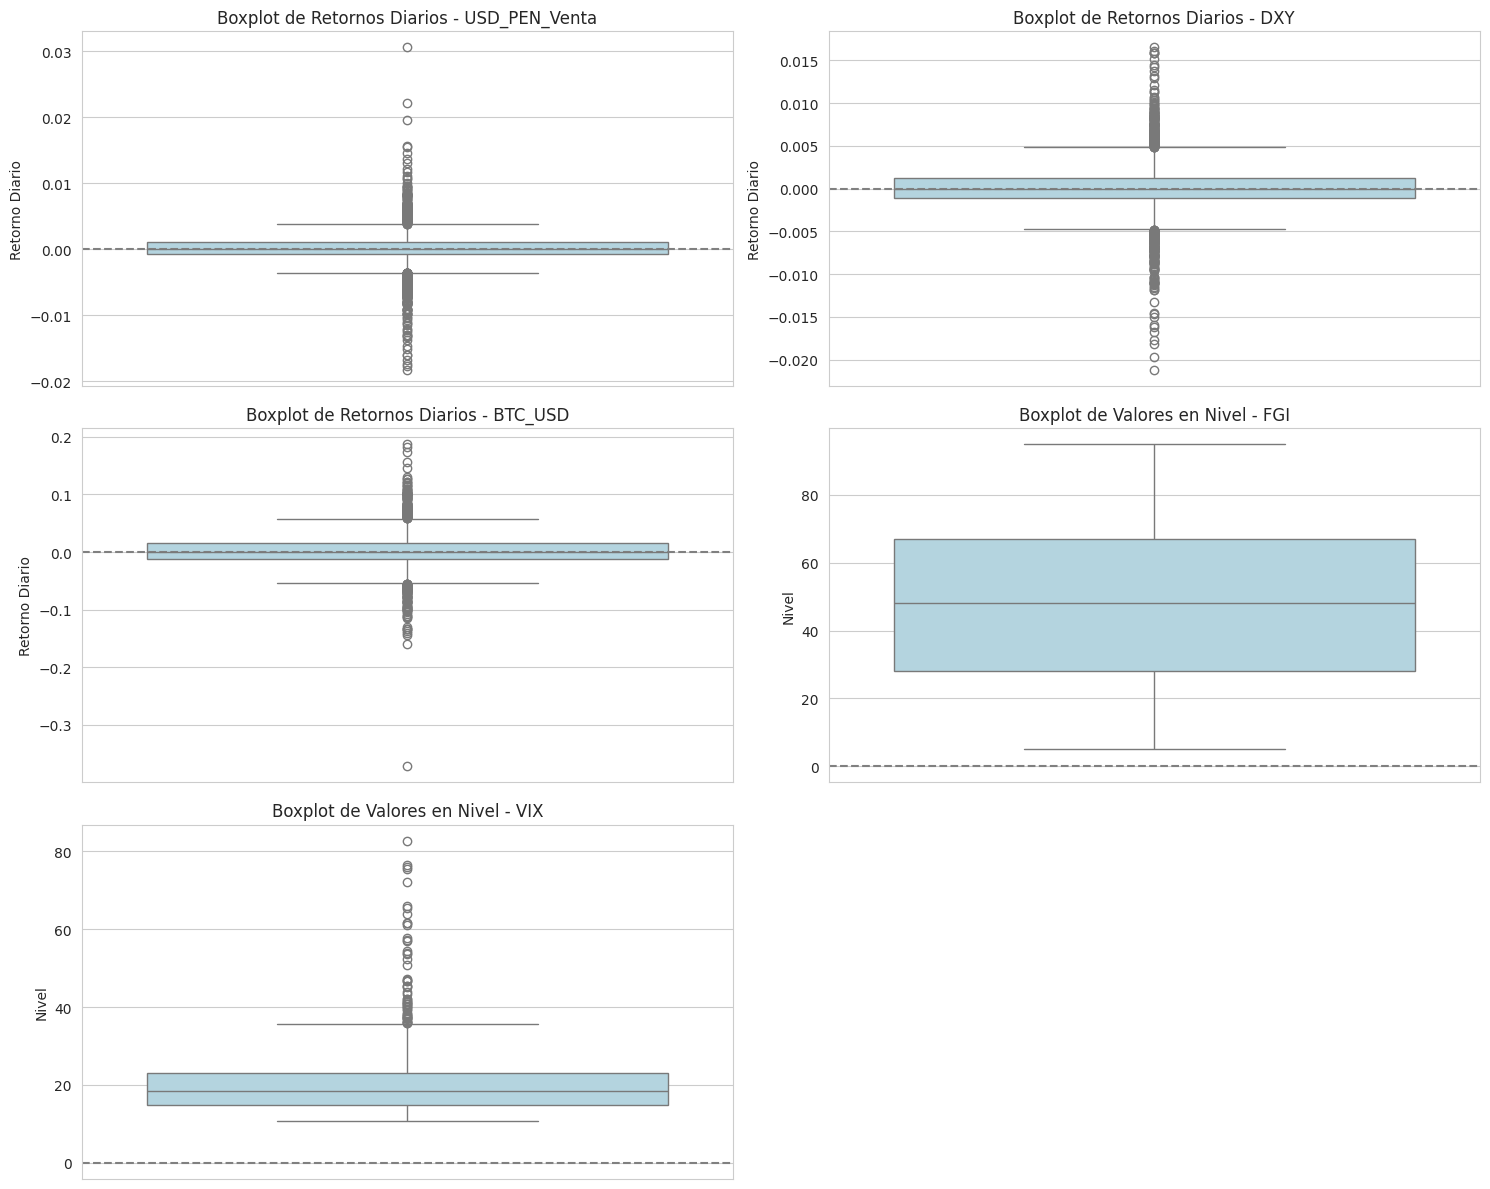

In [84]:
# ============================
# 10. Boxplots de Retornos y Valores en Nivel
# ============================
returns = dataset[["USD_PEN_Venta", "DXY", "BTC_USD"]].pct_change().dropna()
variables_nivel = ["FGI", "VIX"]  # Valores en nivel a graficar
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# 1. Boxplots de retornos diarios
for i, var in enumerate(returns.columns):
    sns.boxplot(y=returns[var], color='lightblue', ax=axes[i])
    axes[i].set_title(f"Boxplot de Retornos Diarios - {var}", fontsize=12)
    axes[i].set_ylabel("Retorno Diario")
    axes[i].axhline(0, color='grey', linestyle='--')

# 2. Boxplots de valores en nivel (FGI y VIX)
for j, var in enumerate(variables_nivel):
    ax_pos = len(returns.columns) + j  # Posición correcta en la figura
    sns.boxplot(y=dataset[var], color='lightblue', ax=axes[ax_pos])
    axes[ax_pos].set_title(f"Boxplot de Valores en Nivel - {var}", fontsize=12)
    axes[ax_pos].set_ylabel("Nivel")
    axes[ax_pos].axhline(0, color='grey', linestyle='--')

# 3. Eliminar subplot sobrante si existe
if len(axes) > len(returns.columns) + len(variables_nivel):
    for k in range(len(returns.columns) + len(variables_nivel), len(axes)):
        fig.delaxes(axes[k])
plt.tight_layout()
plt.show()


***Interpretación:***
Los boxplots permiten comparar la dispersión y la presencia de valores extremos en cada variable:

- USD/PEN (retornos diarios):
La caja es muy estrecha y los bigotes están cercanos al cero, lo que confirma la baja volatilidad del tipo de cambio peruano. Los pocos valores atípicos refuerzan la idea de un mercado cambiario relativamente estable, en gran parte por la intervención activa del BCRP, que mitiga choques externos y contribuye a mantener la confianza en la moneda.

- DXY (retornos diarios):
Presenta una caja también reducida, aunque algo más amplia que la del PEN/USD, con varios valores atípicos. Esto muestra que el dólar estadounidense como índice global es un activo generalmente estable, pero con episodios de movimientos bruscos ligados a cambios en las condiciones macroeconómicas internacionales, especialmente en torno a decisiones de política monetaria de la Reserva Federal.

- BTC/USD (retornos diarios):
Es el activo con mayor dispersión: la caja es mucho más ancha y los outliers son numerosos, incluyendo algunos extremadamente alejados. Esto refleja la alta volatilidad del Bitcoin, asociada a su naturaleza especulativa, descentralizada y fuertemente influida por el sentimiento de los inversionistas, lo que lo hace considerablemente más riesgoso en comparación con monedas tradicionales.

- VIX (niveles):
El boxplot muestra una caja relativamente amplia y con muchos valores extremos hacia arriba. Esto confirma que el índice de volatilidad suele mantenerse en niveles bajos a moderados, pero tiene picos abruptos en episodios de incertidumbre global. La abundancia de outliers indica que los shocks de volatilidad son recurrentes en los mercados financieros internacionales.

- FGI (niveles):
Su caja es amplia y se concentra en valores intermedios (entre 30 y 70), pero con dispersión hacia ambos extremos. Esto sugiere que el índice de Miedo y Codicia captura tanto episodios de optimismo como de temor en el mercado de criptomonedas, aunque su comportamiento es menos extremo que el de los retornos del Bitcoin.

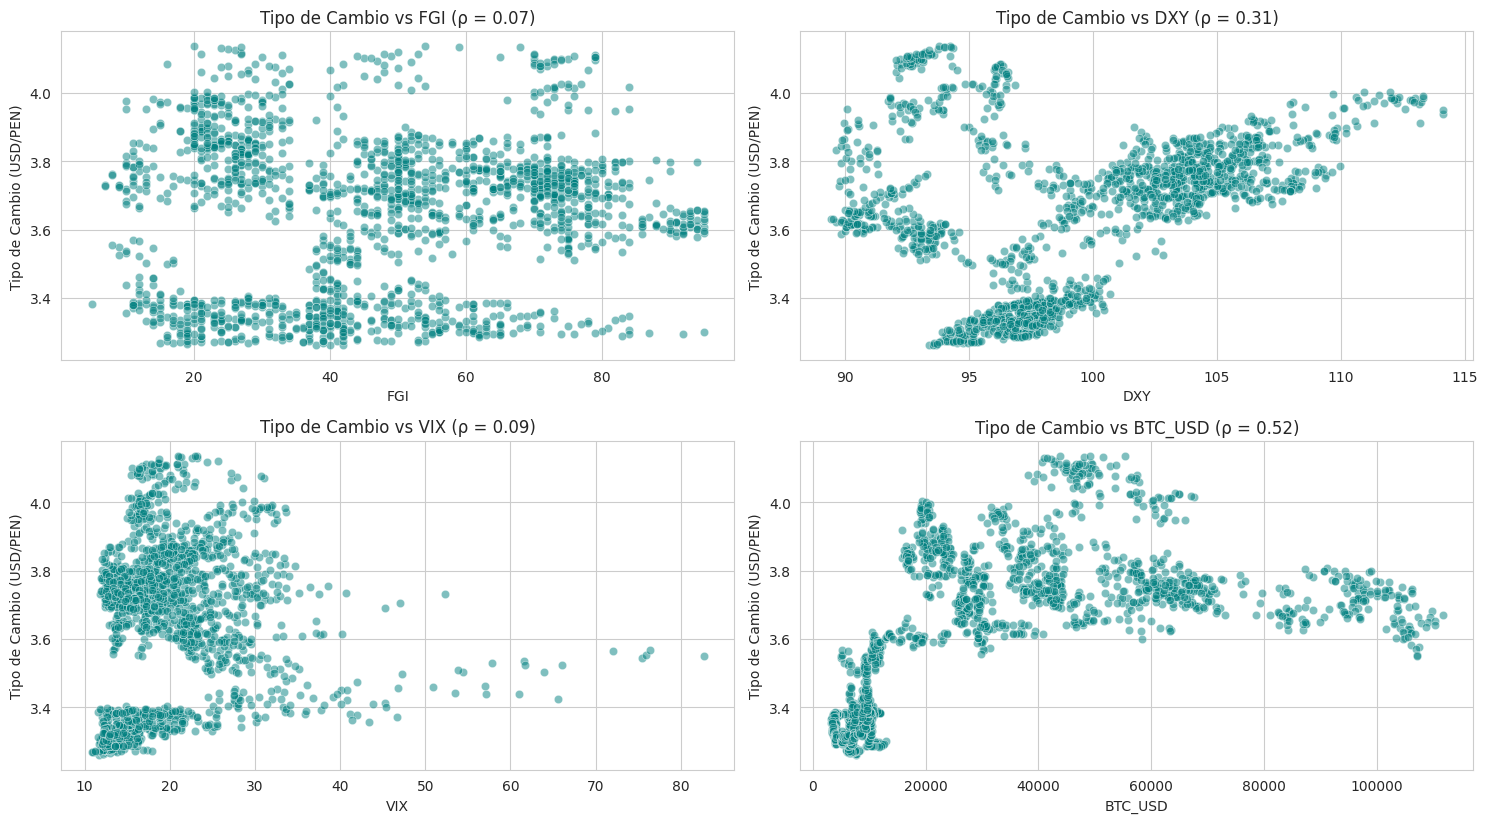

In [85]:
# ====================================
# 11. Gráficos de dispersión y correlación
# ====================================
comparaciones = ["FGI", "DXY", "VIX", "BTC_USD"]  # Variables a comparar contra el tipo de cambio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Gráfico de dispersión entre tipo de cambio y la variable en nivel
for i, var in enumerate(comparaciones):
    sns.scatterplot(x=dataset[var], y=dataset["USD_PEN_Venta"], alpha=0.5, color='teal', ax=axes[i])
    corr = dataset[["USD_PEN_Venta", var]].corr().iloc[0, 1]
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Tipo de Cambio (USD/PEN)")
    axes[i].set_title(f"Tipo de Cambio vs {var} (ρ = {corr:.2f})")
    axes[i].grid(True)

# Eliminar subplot sobrante (6to)
if len(comparaciones) < len(axes):
    for j in range(len(comparaciones), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


***Interpretación:***
- FGI vs Tipo de Cambio (ρ = 0.07):
La nube de puntos no muestra un patrón claro y el coeficiente de correlación es muy bajo. Esto indica que el índice de Miedo y Codicia aplicado al Bitcoin prácticamente no se relaciona con el tipo de cambio USD/PEN. En otras palabras, el sentimiento de los inversionistas en el mercado cripto no parece influir de manera significativa sobre la dinámica cambiaria en el Perú.

- DXY vs Tipo de Cambio (ρ = 0.31):
Se observa una relación positiva moderada: cuando el dólar estadounidense se fortalece globalmente (DXY más alto), el sol peruano tiende a depreciarse (sube el USD/PEN). Esto tiene sentido, pues el DXY refleja la fortaleza del dólar frente a otras monedas, y en un contexto global de apreciación del dólar, las monedas emergentes como el sol suelen verse presionadas a la baja.

- VIX vs Tipo de Cambio (ρ = 0.09):
La relación es débil, sin un patrón definido. Aunque en teoría un mayor riesgo global (medido por el VIX) podría depreciar al sol por salida de capitales, en la práctica la correlación es muy baja. Esto puede reflejar que el BCRP logra contener los efectos de episodios de incertidumbre internacional sobre el tipo de cambio mediante su intervención cambiaria.

- BTC/USD vs Tipo de Cambio (ρ = 0.52):
Aquí sí se observa la relación más fuerte, con un coeficiente moderado-alto. La dispersión sugiere que cuando el precio del Bitcoin se incrementa, el tipo de cambio USD/PEN también tiende a subir (es decir, el sol se deprecia). Esto podría interpretarse como que los periodos de auge o caída en el Bitcoin están asociados a cambios en la demanda por dólares en el Perú, reflejando posibles efectos indirectos de los flujos hacia activos de riesgo.

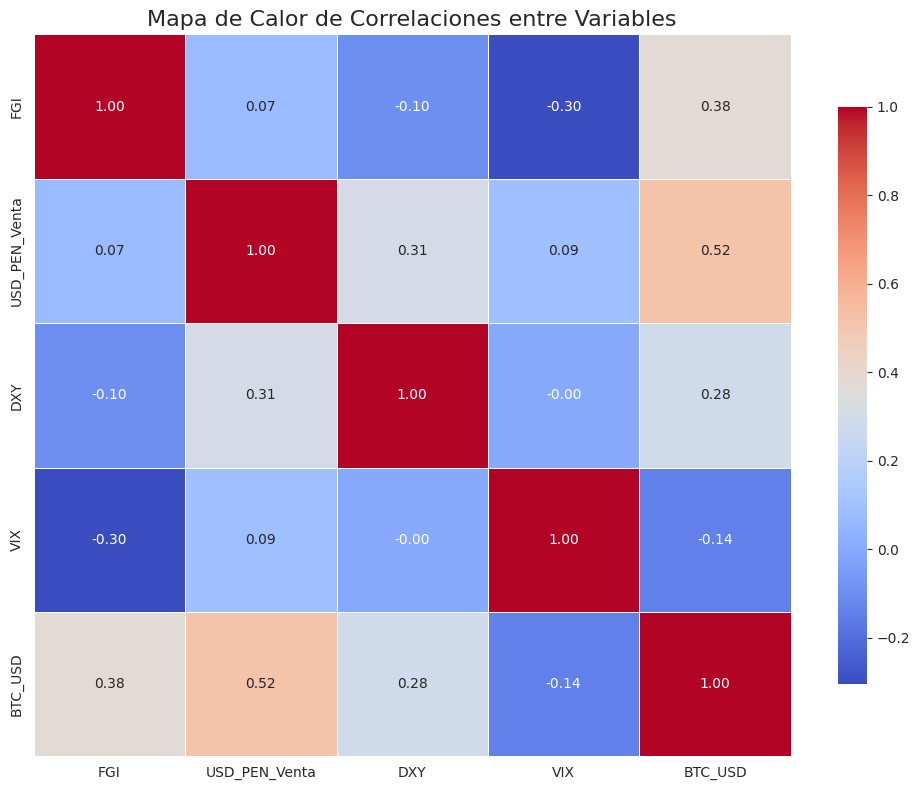

In [86]:
# ================================
# 12. Mapa de Calor de Correlaciones
# ================================

# Calculamos la matriz de correlación entre todas las variables en nivel
corr_matrix = dataset.corr()

plt.figure(figsize=(10, 8)) # Tamaño del gráfico

# Generamos el mapa de calor
sns.heatmap(
    corr_matrix,              # Matriz de correlaciones
    annot=True,               # Mostrar valores dentro de cada celda
    cmap='coolwarm',          # Escala de colores (azul = negativo, rojo = positivo)
    fmt=".2f",                # Formato de los valores (2 decimales)
    linewidths=0.5,           # Grosor de las líneas divisorias
    cbar_kws={"shrink": 0.8}  # Ajuste del tamaño de la barra de colores
)

plt.title('Mapa de Calor de Correlaciones entre Variables', fontsize=16)    # Título
plt.tight_layout()  # Ajuste automático de márgenes
plt.show()  # Mostrar gráfico




***Interpretación:***
- El mapa de calor de correlaciones sintetiza las relaciones estadísticas entre todas las variables analizadas. El resultado más relevante es la correlación positiva moderada-alta entre el tipo de cambio USD/PEN y el precio de Bitcoin (BTC_USD) (ρ = 0.52). Esto sugiere que los periodos de auge o caída en el Bitcoin podrían estar asociados a cambios en la demanda por dólares en el Perú, reflejando posibles efectos indirectos de los flujos hacia activos de riesgo.
- La correlación entre el tipo de cambio USD/PEN y el índice DXY es positiva y moderada (ρ = 0.31). Esto confirma que la evolución del sol peruano está influida por la fortaleza del dólar en los mercados internacionales, un hallazgo consistente con la literatura económica sobre economías abiertas y dolarizadas.
- La relación del tipo de cambio con el VIX aparece débil (ρ = 0.09), lo que sugiere que la volatilidad global no se traslada directamente al mercado cambiario peruano, aunque en episodios de crisis extremas puede intensificar movimientos temporales.
- El Bitcoin muestra correlaciones muy bajas o nulas con las variables tradicionales como el DXY y el VIX, lo que refuerza la idea de que opera como un activo independiente y altamente especulativo, con una dinámica que responde más al comportamiento interno del mercado cripto que a variables macroeconómicas globales.
- Finalmente, el Fear & Greed Index presenta correlaciones mínimas con las demás variables, lo que implica que es un indicador útil para analizar el sentimiento específico de los inversionistas en criptomonedas, pero con poca relevancia para explicar la evolución de los mercados tradicionales como el cambiario o de renta fija.